In [1]:
%matplotlib inline

from IPython.display import HTML, display
import math
import sys
import pprint

pp = pprint.PrettyPrinter(indent=4)

# Module 8 - Programming Assignment (Summer)

# The Problem

When we last left our agent in Module 4, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

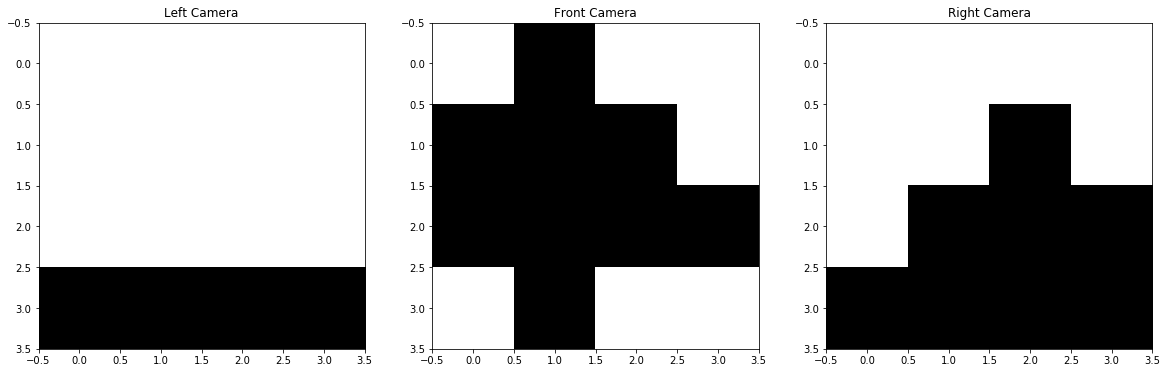

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, you can refer to **module-8-pseudocode.pdf** and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

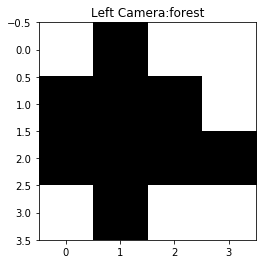

In [5]:
view_sensor_image( clean_data[ "forest"][0])

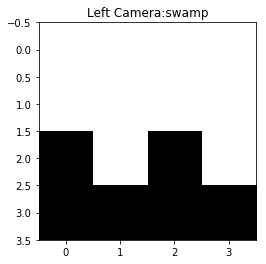

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

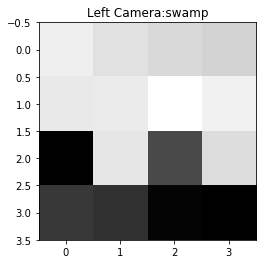

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `calculate_confusion_matrix`


### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, a logistic regression that determines if a sensor image is hills (1) or not (0).

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes, in this case "hills" and "not hills". This means you should probably generate training data with, say, 100 hills and then 100 of all the other types of terrain combined.

When you send your data to the actual `learn_model` function, it will need to have all the String labels transformed to 0 or 1 appropriately. Remember, you also need to set $x_0$ = 1.0; *where* you do that is up to you but you need to be consistent (if you do it in `generate_data` then don't also do it in `learn_model` or `apply_model`.

You can make `generate_data` as sophisticated as you like. But it should at least take n and a label so that:

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

I should also mention that gradient descent is not the usual approach to linear|logistic regression because the error function actually has an *exact* solution. However, in the case of large data sets, the exact solution often fails and in any case, the use of gradient descent will prepare you for neural networks next week.

When verbose is True, you should print out the error so you can see that it is getting smaller. 

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a Tuple of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19).

If the data is labeled, you will return a Tuple of the actual value (0 or 1) and the predicted value (0 or 1). In this case, you return a List of something like [(0, 1), (1, 1), (0, 0), (1, 0)].

### `calculate_confusion_matrix`

The `calculate_confusion_matrix` takes the results of `apply_model` when labeled=True and prints a nice HTML version of a confusion matrix and include statistics for error rate, true positive rate and true negative rate.


**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (and not to be modifying a copy)**

---

## Helper Functions

&nbsp;

**Generate Hills**

This is a helper function for the generate_data function.  Given the clean data, n, a label, and an array data_out that represents the data that will be returned by generate_data, this function generates n blurred hills using the blur function and the clean data.  It iterates through the different options for hill data to return an equal number of the different types of hills.  Each hill is added to the data_out array.

In [9]:
def generate_hills(data, n, label, data_out):
    hill_index = 0
    for i in range(n):
        blurred_hill = blur(data[label][hill_index])
        blurred_hill[-1] = 1.0
        blurred_hill.insert(0, 1.0)  # Add x_0 of 1
        data_out.append(blurred_hill)

        if hill_index < 3:
            hill_index += 1
        else:
            hill_index = 0

&nbsp;

**Generate Not Hills**

This is a helper function for the generate_data function. Given the data n, a label, and an array data_out that represents the data that will be returned by generate_data, this function generates n blurred data points that are not hills.  It iterates through the different options for data that are not hills to return an equal number of the different types of non hill data. Each data point is added to the data_out array.

In [10]:
def generate_not_hills(data, n, label, data_out):
    not_hill_data = []
    for key in data:
        if key != label:
            for data_point in data[key]:
                not_hill_data.append(data_point)

    not_hill_index = 0
    for i in range(n):
        blurred_not_hill = blur(not_hill_data[not_hill_index])
        blurred_not_hill[-1] = 0.0
        blurred_not_hill.insert(0, 1.0)  # Add x_0 of 1
        data_out.append(blurred_not_hill)

        if not_hill_index < 6:
            not_hill_index += 1
        else:
            not_hill_index = 0

&nbsp;

**Dot Product**

This function calculates the dot product of a list of thetas and a list of xs.  The dot product of two vectors a and b is a⋅b = a1b1 + a2b2 + a3b3 +...+ anbn.  This is used to calculate y hat.
 

In [11]:
def dot_product(thetas, xs):
    z = 0
    xs_no_y = xs[0:len(xs) - 1]
    if len(thetas) != len(xs_no_y):
        print '\n\n\nthetas length different than xs\n\n\n'

    for i in range(len(thetas)):
        z += thetas[i] * xs[i]

    return z

&nbsp;

**Calculate y hat**

This function calculates y hat given a list of thetas and a list of xs.  The formula for y hat is:
$$\hat{y} = \frac{1}{1+e^{-\theta_0}}$$

In [12]:
def calculate_yhat(thetas, xs):
    z = dot_product(thetas, xs)
    yhat = 1 / (1 + math.e ** (-z))

    if yhat < 0 or yhat > 1:
        print '\n\n\nyhat not in range 0, 1\n\n\n'

    return yhat

&nbsp;

**Calculate Error**

This function calculates error using the formula for error for logistic regresstion:
$$J(\theta)=-\frac{1}{n}\sum_i	y_i	log(\hat{y_i})	+	(1	- y_i)log(1	- \hat{y_i})$$

In [13]:
def calculate_error(thetas, train_data):
    error_summation = 0
    for xs in train_data:
        y = xs[-1]
        yhat = calculate_yhat(thetas, xs)

        if yhat == 0 and (1 - yhat) == 0:
            pass

        elif yhat == 0:
            error_summation += ((1 - y) * math.log(1 - yhat))

        elif (1 - yhat) == 0:
            error_summation += (y * math.log(yhat))

        else:
            error_summation += (y * math.log(yhat) + (1 - y) * math.log(1 - yhat))

    n = len(train_data)
    error = - (1.0 / n) * error_summation

    return error

&nbsp;

**Derivative**

This function calculates the dertivate using the y hat function. The formula used to calculate the derivative is:
$$\frac{\partial	J}{\partial	\theta_j}	=	\frac{1}{n}\sum_i(\hat{y_i}	- y_i)x_{ij}$$

In [14]:
def derivative(j, thetas, train_data):
    derivative_summation = 0

    n = len(train_data)

    for xs in train_data:
        y = xs[-1]
        yhat = calculate_yhat(thetas, xs)
        xij = xs[j]

        derivative_summation += (yhat - y) * xij

    deriv = (1.0 / n) * derivative_summation
    return deriv

&nbsp;

**Print HTML Table**

This function prints a nicely formated HTML table given a list of lists.  It is used to print the confusion matrix.

In [15]:
def print_html_table(data):
    display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
     ))

---


## Main Functions

Use `generate_data` to generate 10 blurred "hills" examples with balanced (same number of) "non hills" examples to see that the function is working.

In [16]:
def generate_data(data, n, label):
    data_out = []
    generate_hills(data, n, label, data_out)
    generate_not_hills(data, n, label, data_out)

    return data_out

results = generate_data( clean_data, 10, "hills")
print_html_table(results)
#for result in results:
#    print result

1.0,0.102632128446,0.0740703308802,0.098461296359,0.00569742562448,0.103157705715,0.0663106372084,1.0,0.0393398040381,0.101944086186,0.866056298499,0.845682151889,0.898663824714,0.83045293177,0.85705190276,0.801491883898,0.961085602967,1.0
1.0,0.123882856746,0.0599161572128,0.0919985501339,0.215754419118,0.140455975273,0.957238715692,0.150152273736,0.124930302319,0.877899711566,0.725520674564,0.77072700588,0.0787832795145,0.972865731971,0.606450896032,1.0,0.862021457348,1.0
1.0,0.0617591490171,0.0208188034815,0.0567793162505,0.118786854234,0.771484035022,0.0155504858838,0.0538302561751,0.147263001118,0.862971159877,0.933870879154,0.182127720925,0.0962592916957,0.785431681124,0.907775935199,0.921851620288,0.0977707864959,1.0
1.0,0.101271443397,0.179207467786,0.164869118225,0.0887848210918,0.137420036088,0.0933247265431,0.186274794822,0.828123139834,0.14860062564,0.178225164514,0.861578472668,0.966345084226,0.157321772347,0.918111872902,0.932945930946,0.813852496343,1.0
1.0,0.0912487962655,0.0650982590044,0.0603268255944,0.129078049319,0.103392261864,0.103232571604,0.997248767985,0.129800590167,0.123117804014,0.76425690108,1.0,0.947077098355,1.0,1.0,0.853475706394,0.803748189056,1.0
1.0,0.105093697487,0.0647168592495,0.171909909792,0.132041486879,0.0947628337265,0.856580514299,0.0982664994432,0.0,1.0,0.795291126015,0.805537786431,0.157581065922,0.980272331536,1.0,0.879937208661,1.0,1.0
1.0,0.042991411261,0.150129094769,0.161301767748,0.156903151498,1.0,0.0258226382514,0.104386633613,0.067631732525,0.987137622248,0.879783562283,0.0506053988975,0.0905828941408,0.993696115334,0.97271411612,0.845421159762,0.0892763098265,1.0
1.0,0.0882114265326,0.064517879405,0.122632459451,0.018991753229,0.16037942695,0.0443752152253,0.144683346118,0.979628874245,0.120461938955,0.0711231199166,1.0,0.876723587921,0.0,0.77008971255,0.751594965144,0.90757387106,1.0
1.0,0.107274028929,0.04675304364,0.0396307017929,0.100355238941,0.0462366344443,0.023756989781,0.981950330928,0.229646410801,0.171778797321,0.943469223203,0.94586585727,1.0,1.0,0.777302376865,0.824550262361,0.95954153532,1.0
1.0,0.103735270363,0.0439257077307,0.0293180258979,0.120084914757,0.212896961729,0.937764795471,0.0499233881226,0.184497386061,0.947637757376,1.0,0.803625667251,0.0983558538537,1.0,0.800524419183,0.84122512349,1.0,1.0
1.0,0.16316043532,0.162903405497,0.168781390441,0.131512408878,0.0281366456292,0.160823886025,0.156578421416,0.0319856407698,0.0994816637491,0.127803957098,0.133669913539,0.141826574553,0.904597688287,0.942130821298,0.800490679253,0.825666706141,0.0


Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set with 100 hills examples. **Set Verbose to True**

In [17]:
def learn_model(train_data, verbose=False):
    epsilon = 1 / 10000000.0
    alpha = 0.1
    m = len(train_data[0]) - 1
    thetas = [random.uniform(-1, 1) for i in range(m)]
    previous_error = 0.0
    current_error = calculate_error(thetas, train_data)
    print_counter = 0
    while abs(current_error - previous_error) > epsilon:
        new_thetas = [0 for i in range(m)]
        for j in range(m): 
            new_thetas[j] = thetas[j] - alpha * derivative(j, thetas, train_data)
        thetas = new_thetas

        if verbose and print_counter % 1000 == 0:
            print 'error: ', current_error
            print

        if current_error > previous_error:
            alpha = alpha / 10.0
            
        previous_error = current_error
        current_error = calculate_error(thetas, train_data)
        print_counter += 1

train_data = generate_data( clean_data, 100, "hills")
#model = learn_model( train_data, True)
model = [-22.400546976561237, -10.451067964042313, -18.6086749056464, -14.1214695347607, -6.36399199170839, 11.428122477078729, 3.0248446407761627, 3.4316227441828544, 12.576993255048198, -10.316226530691987, 10.761316221645709, 12.501387621641353, -9.776272973274683, 0.3172110649805399, 13.275939870295009, 12.24751308359399, -4.983004296479011]


Use `generate_data` to generate 100 blurred "hills" examples with balanced "non hills" examples and use this as your test data. Set labeled=True and generate results to use in `calculate_confusion_matrix`. Print out the first 10 results, one per line.

In [18]:
test_data = generate_data(clean_data, 100, "hills")

def apply_model(model, test_data, labeled=False):
    results = []
    for xs in test_data:
        yhat = calculate_yhat(model, xs)
        predicted = None
        if yhat < .5:
            predicted = 0
        else:
            predicted = 1
        
        
        if labeled:
            actual = xs[-1]
            results.append((actual, predicted))
        else:
           results.append((predicted, yhat))
            
    return results

results = apply_model( model, test_data)
print results

[(1, 0.9999668145231511), (1, 0.9650188894129691), (1, 0.9999997531419534), (1, 0.999111987217161), (1, 0.9992356579533592), (1, 0.9827102196150841), (1, 0.999619538452553), (1, 0.999586115999328), (1, 0.9995101447465782), (1, 0.850540432422011), (1, 0.9999626250108812), (1, 0.9995972872079366), (1, 0.9994417449490253), (1, 0.9967988388503365), (1, 0.9998367097884373), (1, 0.906674121378201), (1, 0.9999987993041294), (1, 0.9999633539465673), (1, 0.998531972183369), (1, 0.960571737482456), (1, 0.9998282303939673), (1, 0.9999967452682015), (1, 0.9998864481171907), (1, 0.95177181255487), (1, 0.9992279308522141), (1, 0.9991453386056075), (1, 0.9942546145052569), (1, 0.9999555407827536), (1, 0.9995215772137487), (1, 0.9998637668751007), (1, 0.9997426641890642), (1, 0.9998087521724053), (1, 0.9999948615214752), (1, 0.9999994976847885), (1, 0.998937954282794), (1, 0.996553145146648), (1, 0.8772877012250547), (1, 0.9764827649922994), (1, 0.9997338490184445), (1, 0.990879964828696), (1, 0.99200

Using the results above, show your confusion matrix for your model.

In [19]:
def calculate_confusion_matrix(results):
    n = len(results)
    TP = 0.0
    FP = 0.0
    FN = 0.0
    TN = 0.0
    for result in results:
        actual = result[0]
        predicted = result[1]
        if actual == predicted:
            if actual == 1:
                TP += 1
            else:
                TN += 1
        
        else:
            if predicted == 1:
                FP += 1
            else:
                FN += 1
    
    print "TP: ", TP
    print "FP: ", FP
    print "FN: ", FN
    print "TN: ", TN
    
    error = (FN + FP) / n
    print "error: ", error * 100.0, "%"
    
    true_positive_rate = TP / (TP + FN)
    print "true_positive_rate: ", true_positive_rate * 100.0, "%"

    true_negative_rate = TN / (TN + FP)
    print "true_negative_rate: ", true_negative_rate * 100.0, "%"

results = apply_model( model, test_data, True)
calculate_confusion_matrix(results)

TP:  97.0
FP:  1.0
FN:  3.0
TN:  99.0
error:  2.0 %
true_positive_rate:  97.0 %
true_negative_rate:  99.0 %
